# Preliminary Data Analysis of the 2017 Yelp Academic Dataset

#### Import important modules

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import json
import pandas as pd
from wordcloud import WordCloud
import csv
import os
import re
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import seaborn as sns
import numpy as np
from sklearn import linear_model, datasets
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

This is a function that we'll use later to plot the results of a linear SVM classifier

In [3]:
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()[0:200]
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    #create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

#### Load in the sample JSON files and view its contents

For the business reviews, we filtered on:
1. Only kept businesses that are restaurants
2. Only kept businesses that were around after 2010

For the user reviews, we filtered on:
1. Only kept user reviews if it pertained to a restaurant
2. Only kept reviews if they were from after 2014
3. From each state, selected a random selection of 5000 reviews

In [6]:
reviews_json = json.load(open("../cleaned_reviews_subset.json"))
biz_json = json.load(open("../cleaned_business_data.json"))

Let's create a dataframe for each of the datasets for reviews and restaurants.

In [8]:
##########################
#First, create a dataframe with star rating, 
#longitude, latitude, number of reviews,
#and state for each restaurant
##########################
states = reviews_json.keys()
latitude_list = []
longitude_list = []
biz_stars_list = []
count_list = []
state_list = []

for biz in biz_json:
    biz_stars_list.append(biz['stars'])
    latitude_list.append(biz['latitude'])
    longitude_list.append(biz['longitude'])
    count_list.append(biz['review_count'])
    state_list.append(biz['state'])

biz_df = pd.DataFrame({'ratings':biz_stars_list, 'latitude':latitude_list, 
                       'longitude': longitude_list, 'review_count': count_list, 
                       'state':state_list})

##########################
#Next, create a dataframe with star rating
# cool indicator, funny indicator, and text for each user review
##########################

reviews_stars_list = []
text_list = []
cool_list = []
funny_list = []

for state in states:
    for review in reviews_json[state]:
        reviews_stars_list.append(review['stars'])
        text_list.append(review['text'])
        cool_list.append(review['cool'])
        funny_list.append(review['funny'])

reviews_df = pd.DataFrame({'ratings':reviews_stars_list, 'text':text_list, 
                       'cool': cool_list, 'funny': funny_list})
        

First, let's plot the distribution of restaurant ratings in our sample.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10c87a450>]], dtype=object)

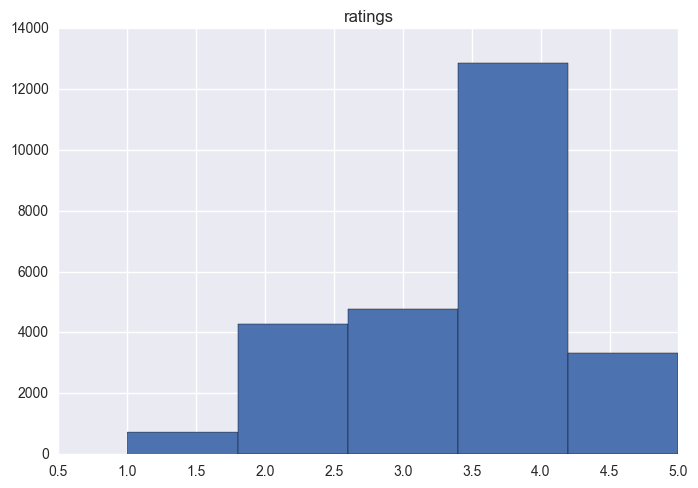

In [9]:
biz_df.hist(column="ratings", bins = 5)

Next, let's plot the distribution of review ratings in our sample

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x127ac47d0>]], dtype=object)

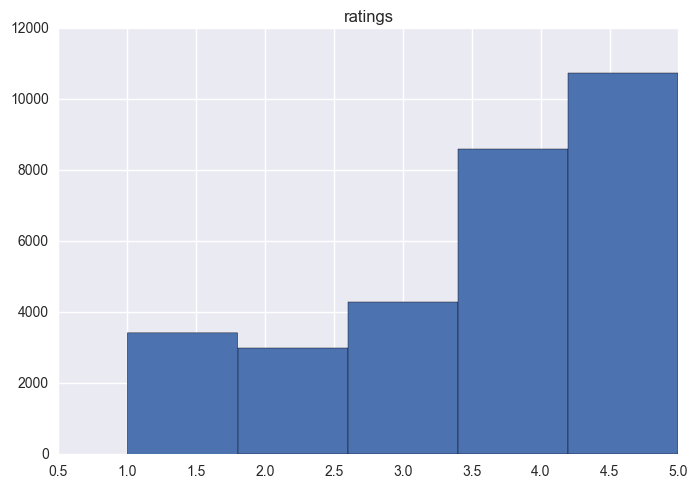

In [10]:
reviews_df.hist(column="ratings", bins = 5)

So one thing we notice right away is that our reviews and restaurant data are not distributed in the same way. The tails are much fatter for the user review data. There are more 1 and 5 star reviews than there are 1 and 5 star restaurants in our sample. 

This implies that we can't draw too many conclusions about restaurants if we only focus on insight gleaned from reviews. If we want to draw conslusions about restaurants based solely on reviews we're either going to have to expand our user reviews data, alter the composition of it through other filters, or filter our business data in some way to better refelct our user data. 

Let's take a look at where the reviews came from

In [11]:
reviews_json.keys()

[u'OH', u'NC', u'WI', u'IL', u'AZ', u'NV']

So we have six different states. I have a hunch that restaurant reviews might be clustered geographically within each state. Let's plot a heatmap of restaurant reviews for each state.

We're going to use the following color coding scheme:

1. Red = Rating of 1
2. Orange = Rating of 2
3. Yellow = Rating of 3
4. Green = Rating of 4
5. Blue = Rating of 5

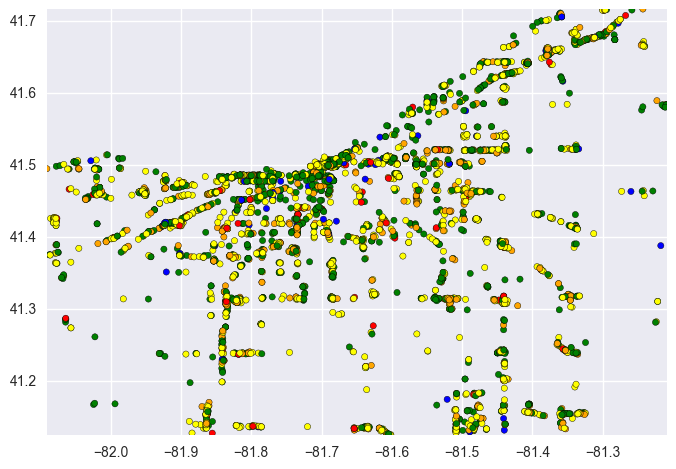

OH


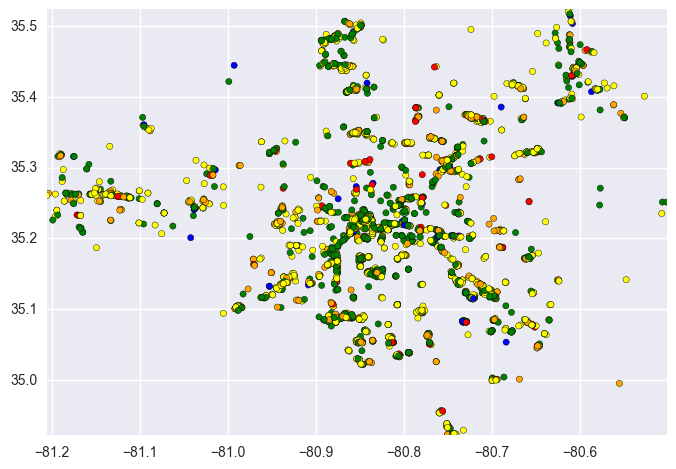

NC


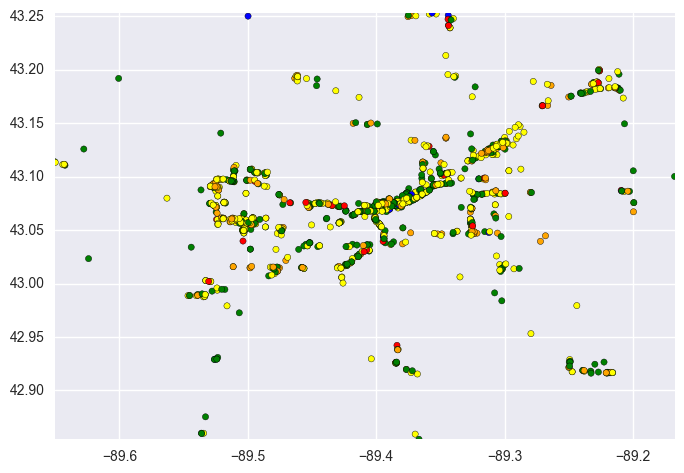

WI


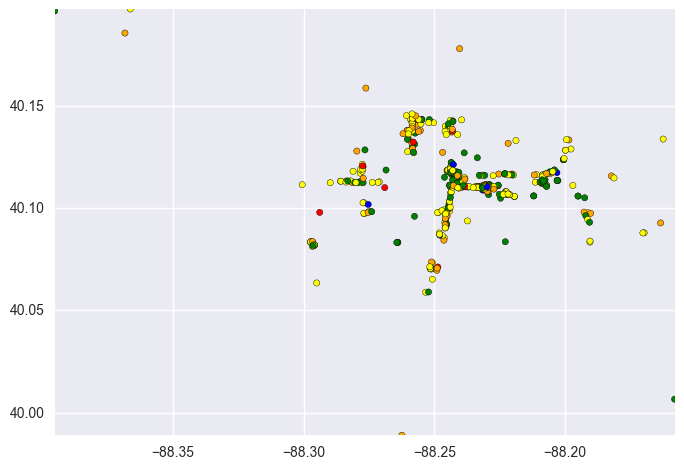

IL


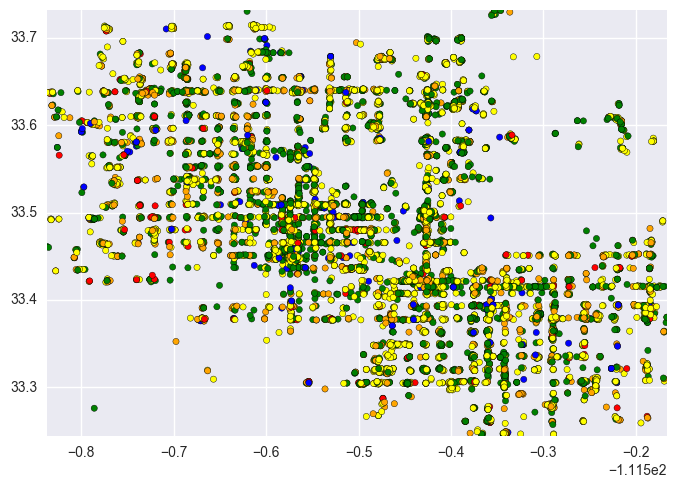

AZ


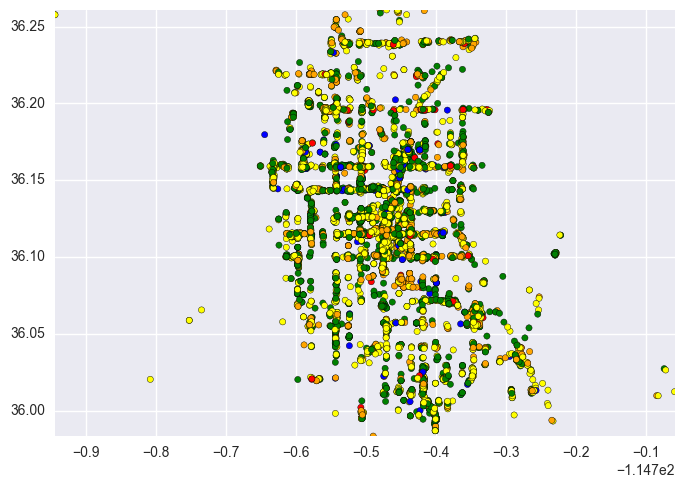

NV


In [12]:
#Create separate heatmaps for each state using the restaurant reviews
cmap, norm = mpl.colors.from_levels_and_colors([1, 2, 3, 4, 5], ['red', 'orange', 'yellow', 'green', 'blue'], extend = 'max')
for state in states:
    state_df = biz_df[biz_df.state == state]
    state_df_filt = state_df[(np.abs(state_df.longitude-state_df.longitude.mean()) <= 2*state_df.longitude.std()) \
                             & (np.abs(state_df.latitude-state_df.latitude.mean()) <= 2*state_df.latitude.std())]
    plt.ylim(min(state_df_filt.latitude), max(state_df_filt.latitude))
    plt.xlim(min(state_df_filt.longitude), max(state_df_filt.longitude))
    
    plt.scatter(state_df_filt.longitude, state_df_filt.latitude, c=state_df_filt.ratings, cmap=cmap, norm=norm)
    plt.show()
    print state

So there doesn't look like there's too much clustering going on, besides for Nevada which has a significant amount of four starred restaurants in the center. This means that for whatever machine learning task we choose to take on later, we won't really have to consider geographic location as a feature except for maybe Nevada.

I think these are more confusing then helpful, but a lot of people like looking at this visualization so lets plot a word cloud on the user review data.

(-0.5, 1439.5, 1079.5, -0.5)

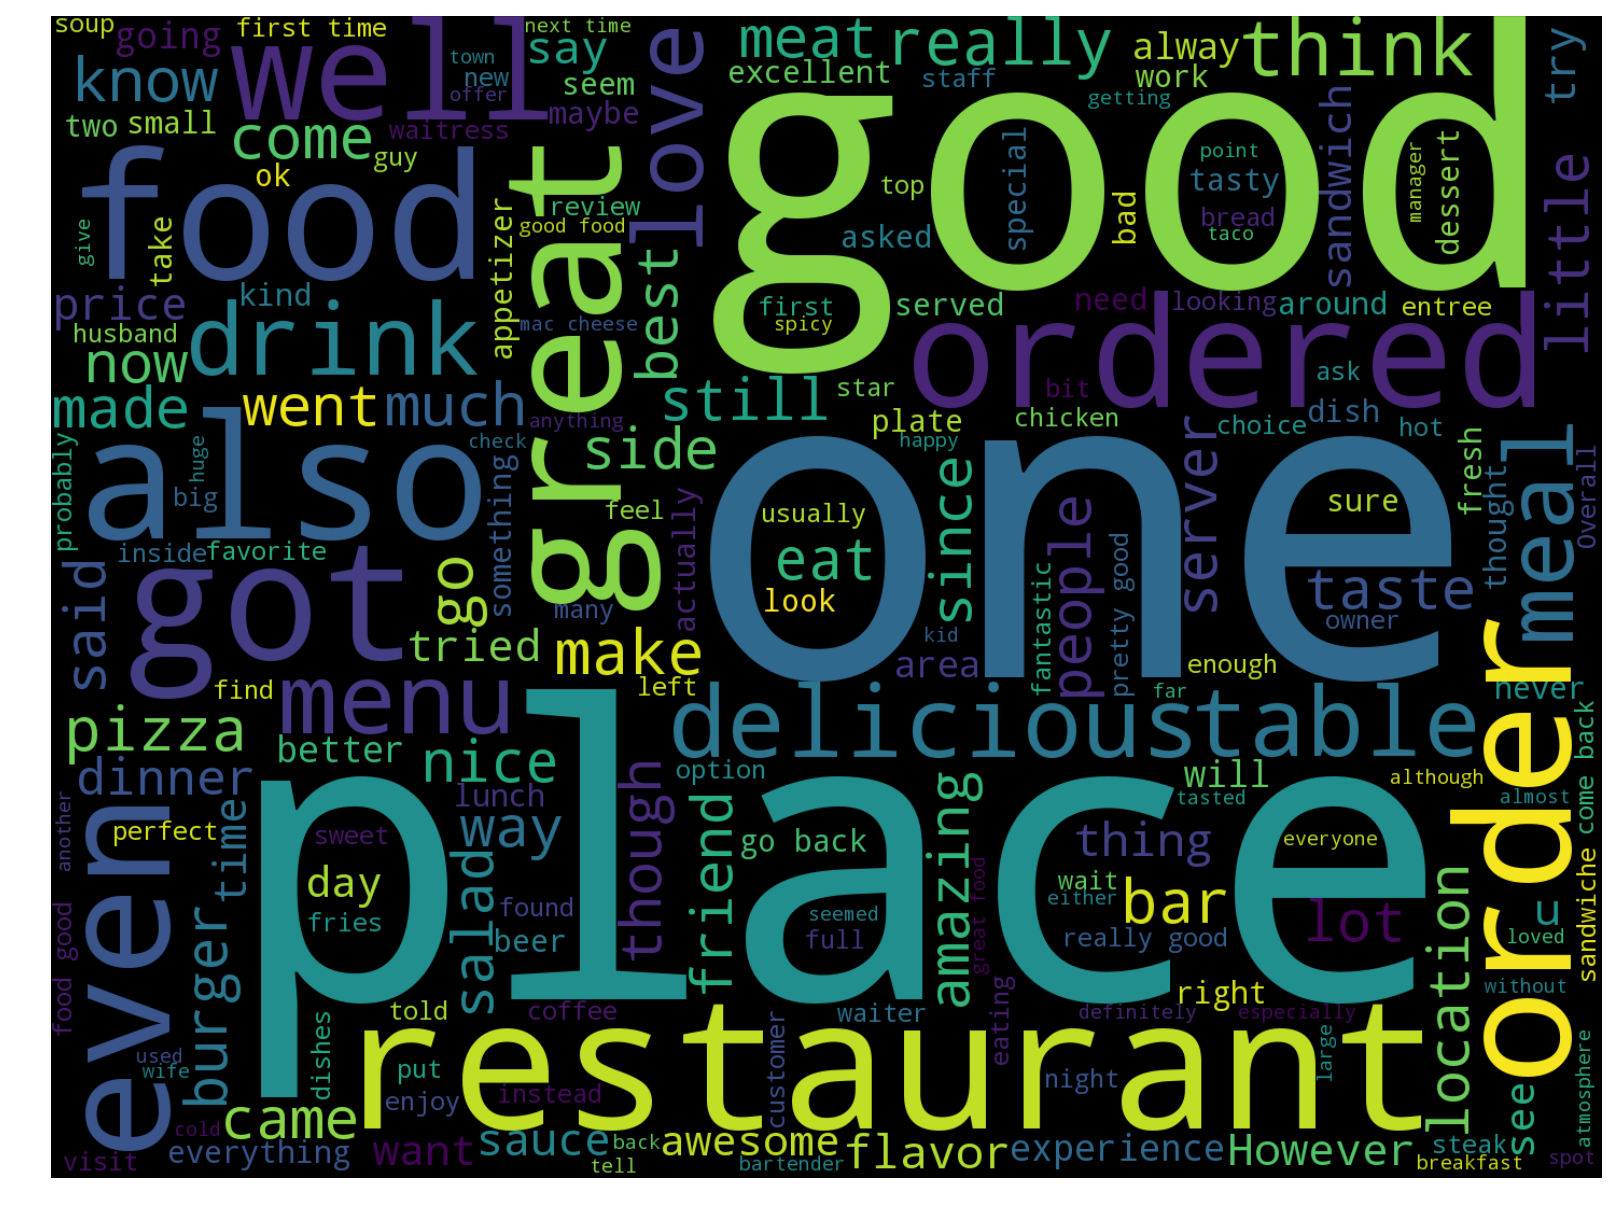

In [58]:
cloud = WordCloud(width=1440, height=1080).generate(" ".join(reviews_series.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

Let's take a look at the lingusitic statistics in our sample of user review data

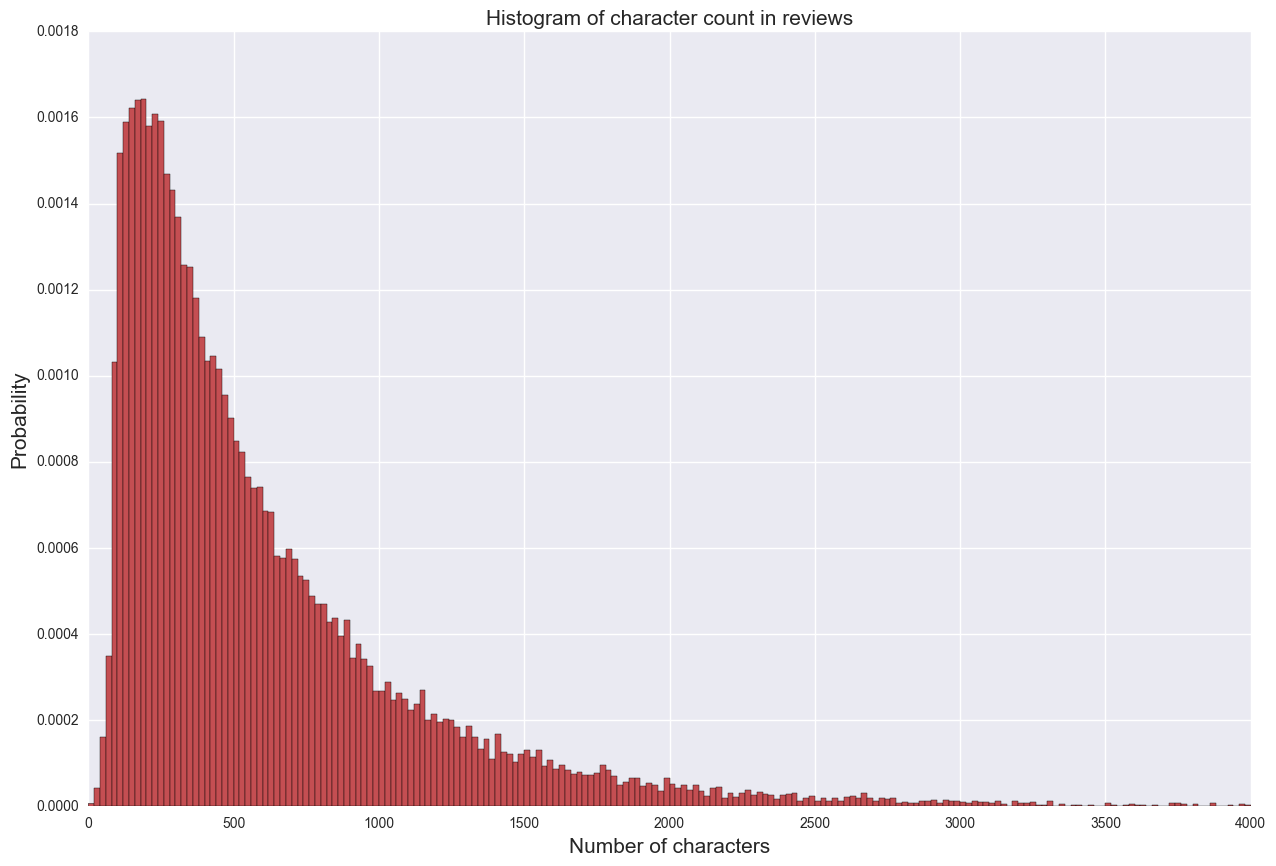

In [57]:
try:
    reviews_df['text'] = [x.encode('utf-8') for x in reviews_df['text']]
except:
    reviews_df['text'] = [str(x) for x in reviews_df['text']]

reviews_series = pd.Series(reviews_df['text'].tolist()).astype('str')
reviews_df['char_count'] = reviews_series.apply(len)
pal = sns.color_palette()

plt.figure(figsize=(15, 10))
plt.hist(reviews_df['char_count'], bins=200, range=[0, 4000], color=pal[2], normed=True)
plt.title('Histogram of character count in reviews', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

It looks like the majority of reviews have 1000 characters or less. Although we do have observations for word counts far into the right tail, we even have observations that have 5000 characters although that isn't shown in the graph. Overall, the distribution is skewed left.

This insight, combined with the rating distribution, implies that most reviews have at least four stars and the majority of them are shorter reviews. I'm curious if character length can explain the review rating. To take a look at this, let's use a multinomial logit model. A multinomial logistic regression is appropriate because the dependent variable (review rating) is a discrete categorical variable and the independent variable (word count) is continuous.

In [56]:
X = np.array(reviews_df['char_count']).reshape(len(X),1)
Y = np.array(reviews_df['ratings']).reshape(len(Y), 1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(X_train, y_train)

yhat = logreg.predict(X_test)

print classification_report(y_test, yhat)

             precision    recall  f1-score   support

          1       0.00      0.00      0.00       695
          2       0.00      0.00      0.00       580
          3       0.09      0.00      0.00       873
          4       0.30      0.16      0.20      1701
          5       0.38      0.90      0.54      2153

avg / total       0.23      0.37      0.25      6002



Unfortunately, it doesn't look like we do very well overall. Especially with lower rated reviews, our f1-score is a solid 0.0. However, we have a nice jump with ratings that have at least 4 stars. Given the distribution of review ratings, this hints that any classification task might be easier for higher rated reviews.

Let's try using a tf-idf representation of the reviews. tf-idf is a bag of words method that uses the relative importance of each word in the entire corpus of documents to weight the importance of that word. You can read more about it here:

https://en.wikipedia.org/wiki/Tf%E2%80%93idf

In [62]:
X = TfidfVectorizer().fit_transform(reviews_df['text'])
Y = np.array(reviews_df['ratings']).reshape(len(Y), 1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(X_train, y_train)

yhat = logreg.predict(X_test)

print classification_report(y_test, yhat)

             precision    recall  f1-score   support

          1       0.63      0.54      0.58       695
          2       0.30      0.29      0.29       580
          3       0.33      0.31      0.32       873
          4       0.40      0.43      0.42      1701
          5       0.61      0.62      0.61      2153

avg / total       0.48      0.48      0.48      6002



So we're doing a bit better with tf-idf features but we're going to need to do some more feature engineering in order to get a proper machine learning classification system but we're off to a good start.

For other resources that took a dive into the Yelp academic dataset, see:

* http://firstmonday.org/ojs/index.php/fm/article/view/4944/3863#p2
* https://www.cs.uic.edu/~liub/publications/kdd04-revSummary.pdf